# ReadMe
This file is intended to streamline the process of analyzing the data resulting from running the experiments in "falsifier.py" and "mult_obj_falsifier.py"

# Imports - TO DO add helpers, streamline process

In [197]:
import pandas as pd
import os
import re
import numpy as np
import ast
import matplotlib.pyplot as plt
import math


# Classify File Instances

In [ ]:
def fix_file(df,ce_locations, non_ce_locations,multi):
    if multi: # multiobj falsifier is a special case
        pass
    else: # velocity, values are in tandem with file ordering in fol



In [ ]:
def classify_simulations(files):
    ce_reg = r'.*\d_cex.*'
    nc_reg = r'.*no_cex.*'
    att_reg = r".*attacker_crash.*"

    ce_loc = []
    non_ce_loc = []


    reg = [ce_reg,nc_reg,att_reg]
    classified_cases = [[],[],[]]
    for simulation_idx in range(len(files)):
        for i in range(len(reg)):
            found = re.match(reg[i],files[simulation_idx])
            if found:
                if i == 0:
                    ce_loc.append(simulation_idx)
                else:
                    non_ce_loc.append(simulation_idx)
                classified_cases[i].append(files[simulation_idx])
                break
    return classified_cases,ce_loc,non_ce_loc

def read_folder(folder,sampler_file, attack_type, velocity_file):    
    """
    Data prepocessing: returns dataframe with test case specific features
    """
    files = os.listdir(folder)
    final,ce_loc,non_ce_loc = classify_simulations(files)


    sum = 0
    for i in final:
        sum += len(i)

    simulation_params_df = pd.read_csv(sampler_file)
    velocities_df = pd.read_csv(velocity_file)

    if attack_type == "int":
        return(preprocess_intermittent(final,simulation_params_df,velocities_df))
    if attack_type == "per":
        return(preprocess_persistent(final,simulation_params_df,velocities_df,ce_loc,non_ce_loc))
    else:
        print("Error classifying attack type")


def preprocess_intermittent(classified_files, sampler_data,velocities_df,):
    intermittent_cols = ["point.params.random_thr_br1","point.params.random_thr_br2","point.params.inter_vehicle_distance", "point.params.random_t1", "point.params.random_t2","point.params.random_t3","point.params.random_t4","point.params.random_thr_br1","rho"]
    sampler_data =sampler_data[intermittent_cols]
    output = get_attack_spacing_intermittent(sampler_data)
    output = velocity_at_attack_intermittent(sampler_data,velocities_df)

    return output


def preprocess_persistent(classified_files,sampler_data,velocities_df,ce_loc,non_ce_loc):
    persistent_cols = [ "Unnamed: 0","point.params.amplitude_acc", "point.params.attack_time", "point.params.frequency", "point.params.inter_vehicle_distance", "rho"]
    sampler_data = sampler_data[persistent_cols]
    output = velocity_at_attack_persistent(velocities_df,sampler_data,True,ce_loc,non_ce_loc)
    return output




# Helper Functions

In [148]:
def get_attack_spacing_intermittent(intermittent_df): # Calculate distance between each attack and add to Dataframe
    attack_spacing = []

    for simulation_instance in range(len(intermittent_df)):
        diff_1 = intermittent_df["point.params.random_t2"][simulation_instance] - intermittent_df["point.params.random_t1"][simulation_instance] # t2 > t1
        diff_2 = intermittent_df["point.params.random_t3"][simulation_instance] - intermittent_df["point.params.random_t2"][simulation_instance]
        diff_3 = intermittent_df["point.params.random_t4"][simulation_instance] - intermittent_df["point.params.random_t3"][simulation_instance]

        sim_gaps = np.array([diff_1,diff_2,diff_3])
        attack_spacing.append(sim_gaps)

    attack_spacing = np.array(attack_spacing)
    col_names = ["t1_t2", "t2_t3", "t3_t4"]
    time_df = pd.DataFrame(attack_spacing, columns=col_names)

    return(pd.concat([intermittent_df, time_df],axis=1))


def velocity_at_attack_intermittent(velocities_df, intermittent_df): # Collect the attackers speed at each attack and append to Dataframe
    simulation_velocities_arr = []
    velocities_df = velocities_df.reset_index(drop=True)
    
    for j in range(0,len(velocities_df)):
        sim_velocities = []
        for i in velocities_df.columns:
            vals = ast.literal_eval(velocities_df[i][j])
            velocities = [i[1] for i in vals]
            sim_velocities.append(velocities)
        
    simulation_velocities_arr.append(np.array(sim_velocities)) #accumulate a single simulation instance

    simulation_velocities_arr = np.array(simulation_velocities_arr)

    
    col_names = ["t1_velocity", "t2_velocity", "t3_velocity", "t4_velocity"]
    velocity_df = pd.DataFrame(simulation_velocities_arr, columns=col_names)

    return(pd.concat([intermittent_df, velocity_df],axis=1))


def velocity_at_attack_persistent(velocities_df, persistent_df, display,ce_loc,non_ce_loc):
    simulation_velocities_arr = []
    velocities_df = velocities_df.reset_index(drop=True)
    
    simulation_velocities_arr = []
    velocities_df = velocities_df.reset_index(drop=True)

    sim_velocities = []
    for j in range(0,len(velocities_df)): # for all simulations
        vals = ast.literal_eval(velocities_df['0'][j]) # evaluate the velocity of the attacker
        velocities = [v[1] for v in vals] # create list of velocities
        sim_velocities.append(velocities)
        
    simulation_velocities_arr.append(np.array(sim_velocities)) #accumulate a single simulation instance
    simulation_velocities_arr = np.array(simulation_velocities_arr)
    
    attack_times= persistent_df["point.params.attack_time"]


    velocity_at_attack = []  # construct custom features
    avg_speed_after_attck = []
    for time in attack_times:
        attack_span = int(time * 10) # account for timestep length
        velocity_at_attack.append(np.average(simulation_velocities_arr[0][0][attack_span-2:attack_span+2])) # average out over a few steps not just instantaneously 
        avg_speed_after_attck.append(np.average(simulation_velocities_arr[0][0][attack_span:])) # collect that average speed after attack has occured

    velocity_at_attack = np.array(velocity_at_attack)
    avg_speed_after_attck = np.array(avg_speed_after_attck)
    col_names = [["pre_attack_velocity"],["attack_velocity_average"]]
    temp_df = pd.DataFrame(velocity_at_attack, columns=col_names[0])
    temp_df2 = pd.DataFrame(avg_speed_after_attck,columns=col_names[1]) 

    if display:
        generate_persistent_attack_graphs(simulation_velocities_arr, persistent_df["point.params.frequency"],persistent_df["point.params.amplitude_acc"],persistent_df["point.params.attack_time"],ce_loc,non_ce_loc)
        


    return(pd.concat([persistent_df,temp_df,temp_df2],axis=1))                                    


# Visualization Tools

In [196]:
print(1.0/10)

0.1


In [ ]:
def generate_persistent_attack_graphs(sim_velocities,att_freq,att_amplitude,times,ce_loc,non_ce_loc): # okay we gonna have to fix this up later
    """
    Graph Velocity over time w/ displayed amplitude    
    """
    for i in range(0,15):
        plt.figure()  #  (1, 500, 252)
        if i in ce_loc:
            type_ex = "Counter-Example"
            param_idx = sum(1 for x in ce_loc if x < i)
            print("COUNTER EXAMPLE IDX",param_idx)
        else:
            type_ex = "Failed Attack"
            param_idx = sum(1 for x in non_ce_loc if x < i) + len(ce_loc)
            print("NON CE IDX",param_idx)
        
        
        x = range(len(sim_velocities[0][param_idx]))
        plt.plot(x,sim_velocities[0][param_idx])

        plt.title(f"Velocity Over time with attack Frequency {int(att_freq[param_idx])} and acceleration amplitude {att_amplitude[param_idx]:.2g} \n Type {type_ex}")

        plt.xlabel(f"Timestep(.1): Attack at {times[param_idx]*10}")
        plt.ylabel(f"Velocity")

        attack_time = round(times[param_idx],1) * 10 
        print(round(times[param_idx],1), times[param_idx])
        plt.axvspan(attack_time-10, attack_time + 10, color='blue', alpha=0.3, label="Attack Interval")



        plt.show()




In [216]:
print(round(9.73,1))

9.7


# Test

In [217]:
file_path = "../outputs/persistent_sa/persistent_attack_sa.csv"
dir_path = "../outputs/persistent_sa"
vel_path = "../outputs/persistent_sa/persistent_attack.scenic_500sa_velocities.csv"

NON CE IDX 17
7.5 7.515833336388608


/home/kay27/2_24_sampling_env/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/kay27/2_24_sampling_env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


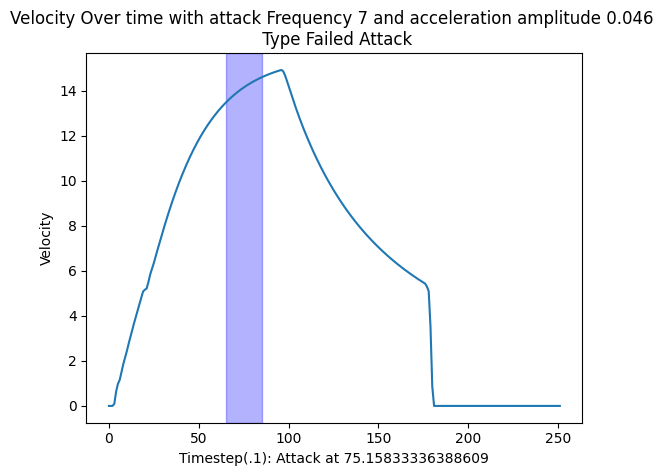

NON CE IDX 18
9.7 9.727264415267472


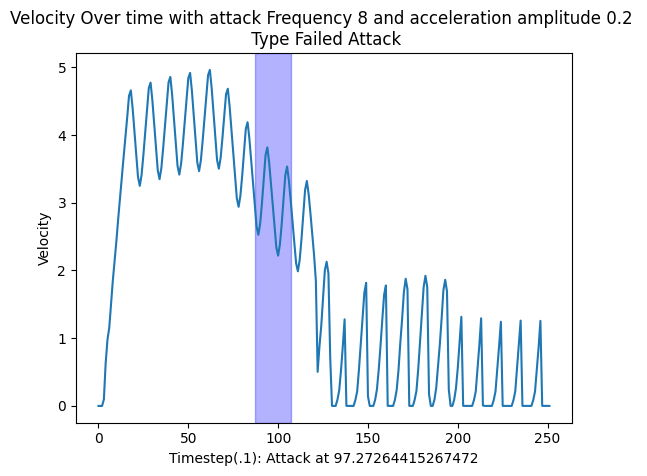

NON CE IDX 19
3.2 3.1595219337681515


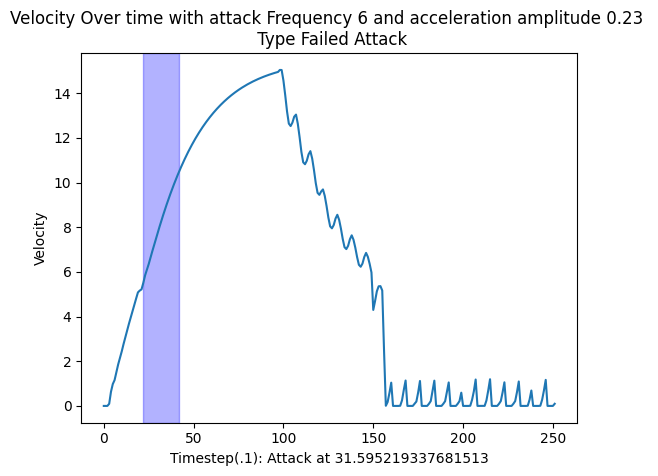

NON CE IDX 20
7.5 7.487495785857542


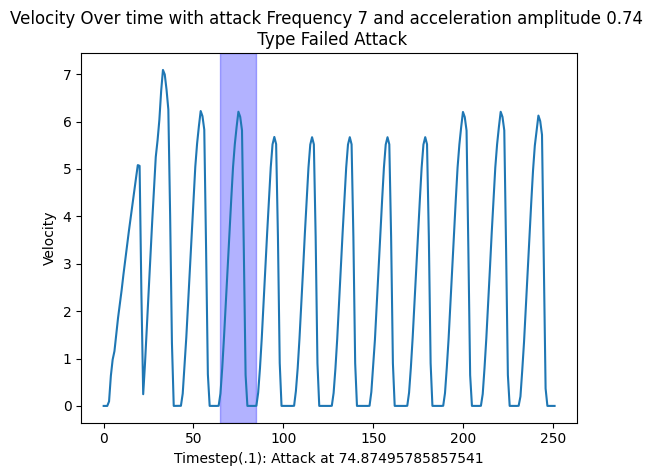

COUNTER EXAMPLE IDX 0
3.6 3.589166624228144


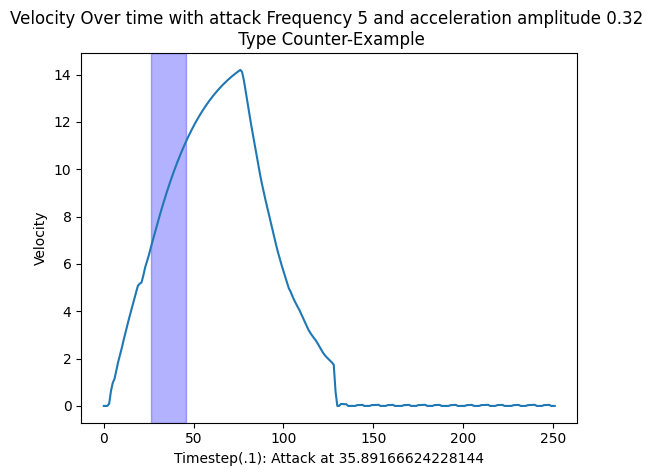

NON CE IDX 21
7.7 7.687728551962567


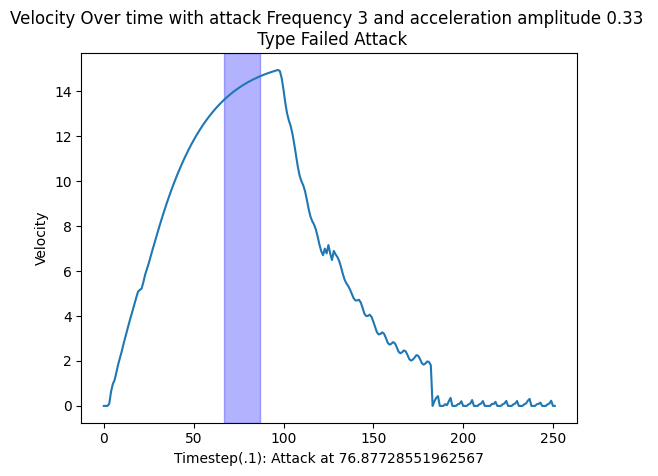

NON CE IDX 22
8.6 8.561429924799965


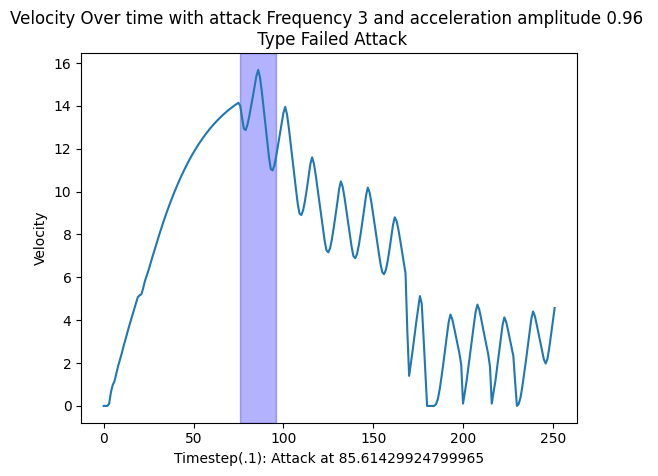

NON CE IDX 23
6.8 6.792704464302757


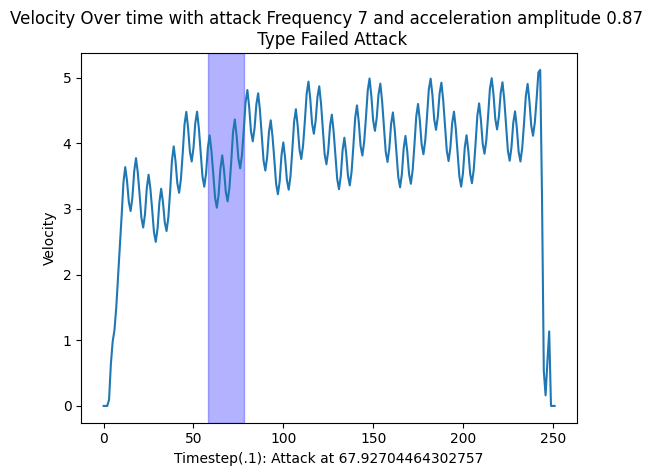

NON CE IDX 24
10.0 9.987761294790625


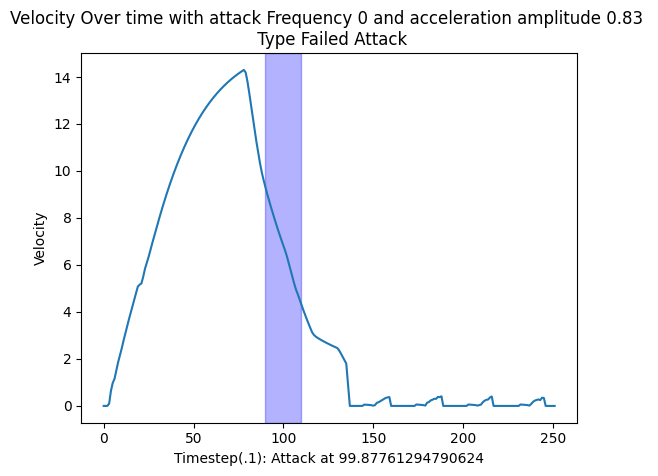

NON CE IDX 25
9.8 9.815543689142087


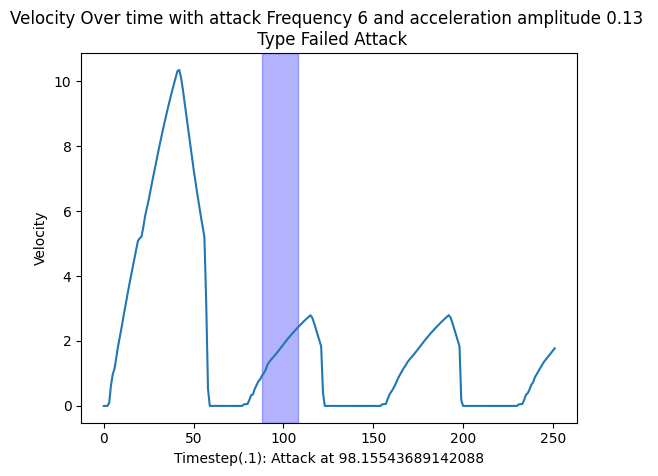

NON CE IDX 26
8.3 8.306651603214098


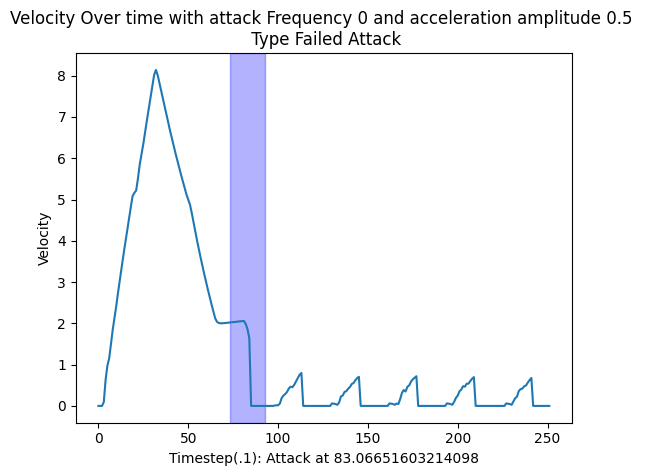

NON CE IDX 27
7.0 7.015200895829999


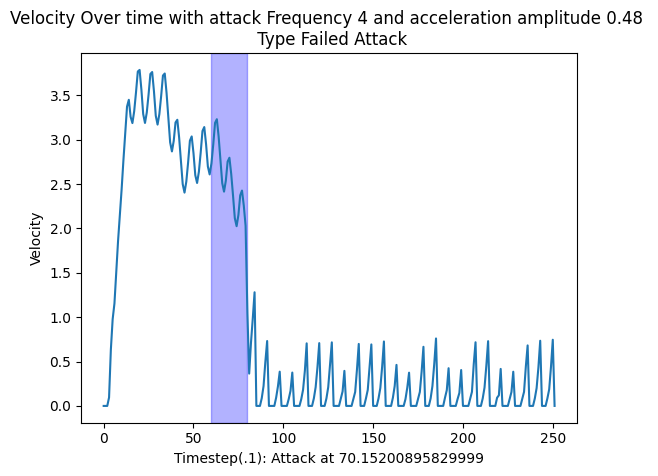

NON CE IDX 28
2.2 2.213814885205674


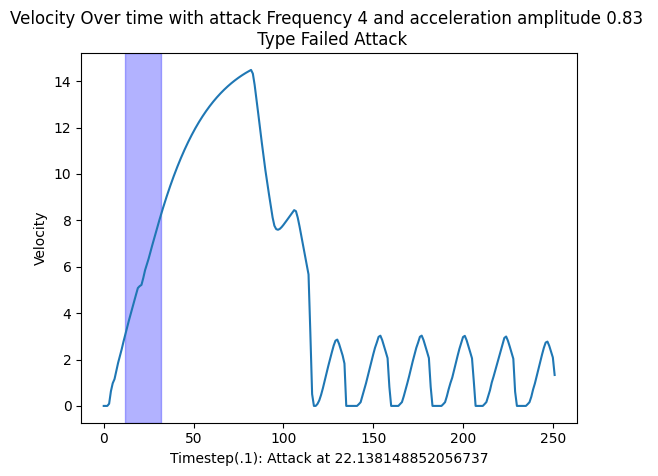

NON CE IDX 29
2.0 1.9551074674051336


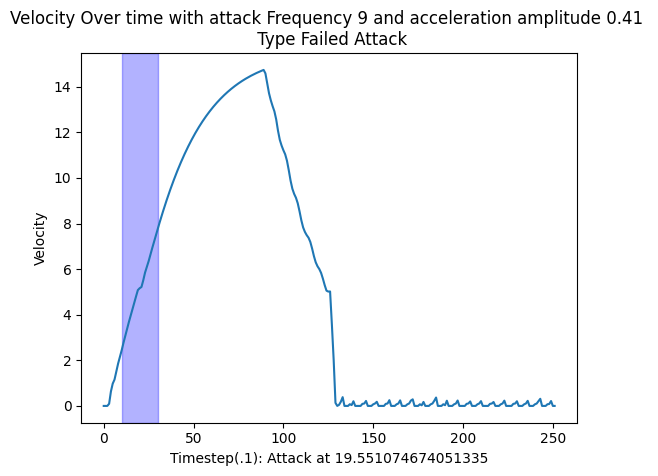

NON CE IDX 30
3.7 3.652897891916808


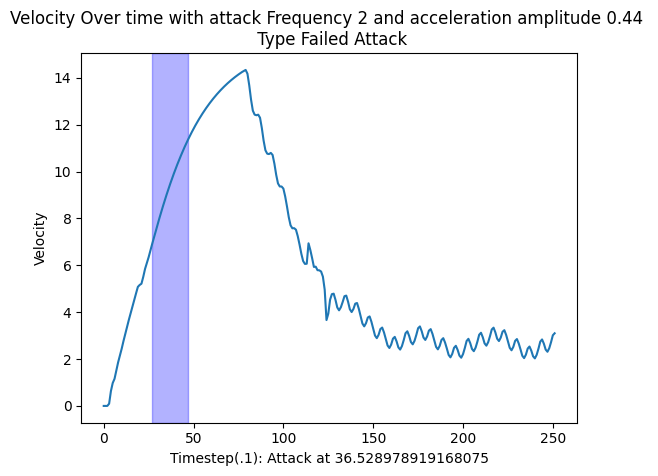

In [218]:
ifitaintbrokedontfix = read_folder(dir_path, file_path,"per",vel_path)

In [85]:
velocities_df = pd.read_csv(vel_path)
all_data = pd.read_csv(file_path)
simulation_velocities_arr = []
velocities_df = velocities_df.reset_index(drop=True)

sim_velocities = []
for j in range(0,len(velocities_df)): # for all simulations
    vals = ast.literal_eval(velocities_df['0'][j]) # evaluate the velocity of the attacker
    velocities = [v[1] for v in vals] # create list of velocities
    sim_velocities.append(velocities)
    
simulation_velocities_arr.append(np.array(sim_velocities)) #accumulate a single simulation instance

simulation_velocities_arr = np.array(simulation_velocities_arr)

#print(all_data.columns)
ce = [3, 67, 72, 80, 84, 101, 135, 140, 155, 168, 184, 207, 211, 226, 275, 350, 351, 418, 440, 455, 466, 478]
non_ce = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501]

22


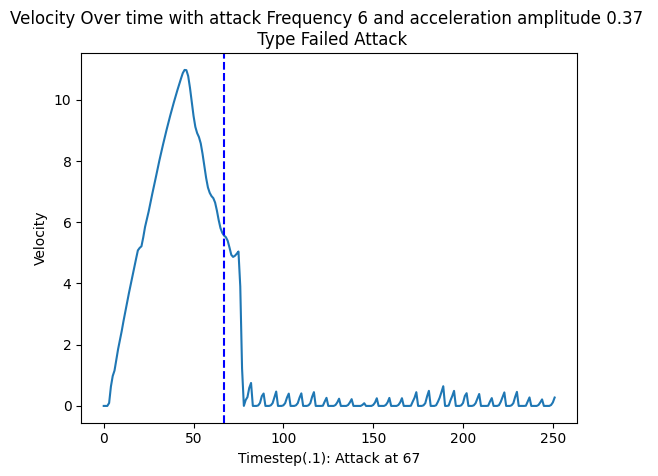

23


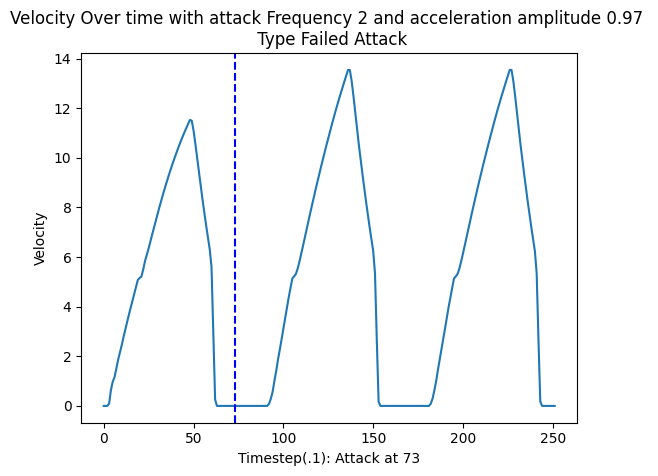

24


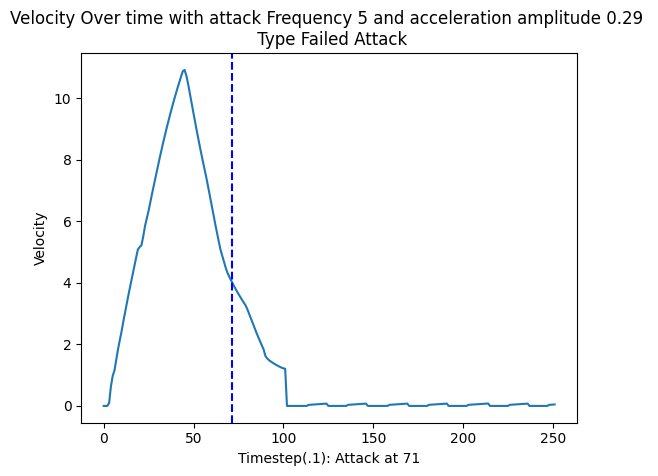

COUNTER EXAMPLE IDX 0


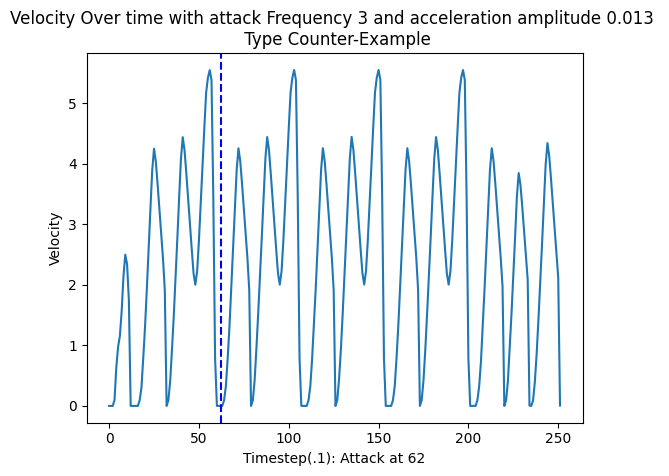

25


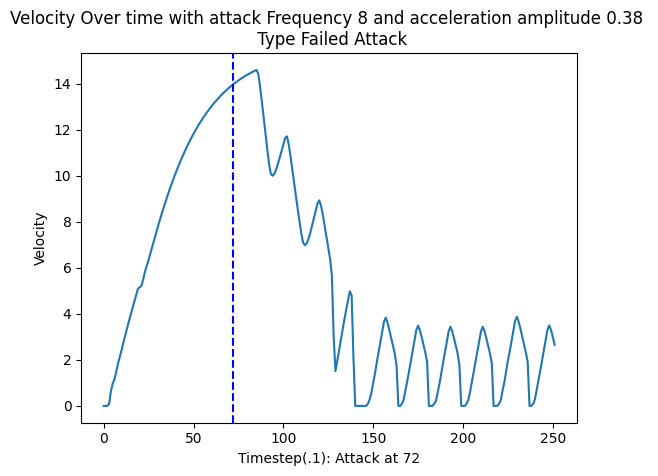

26


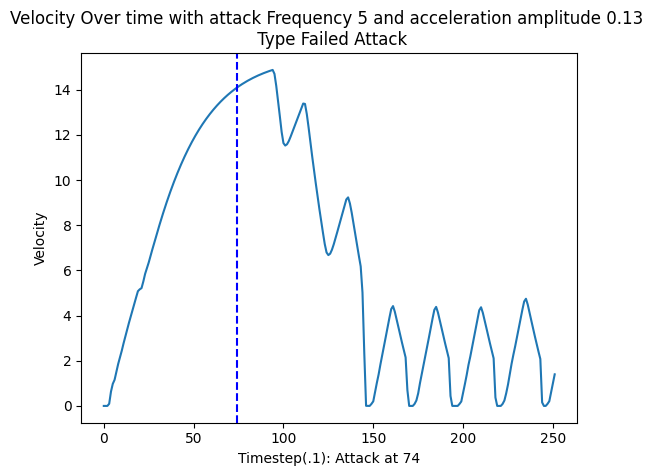

27


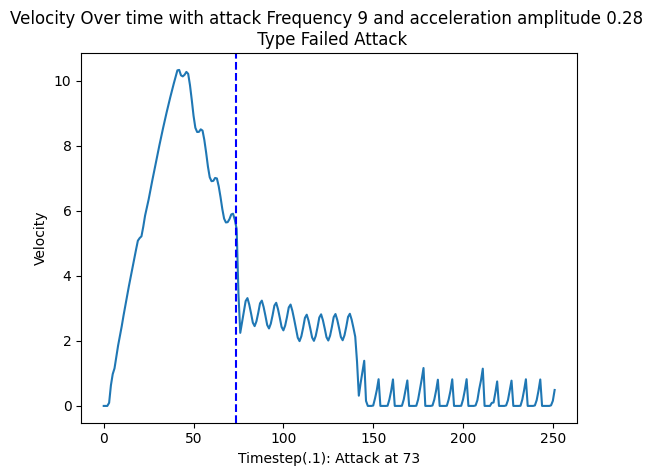

28


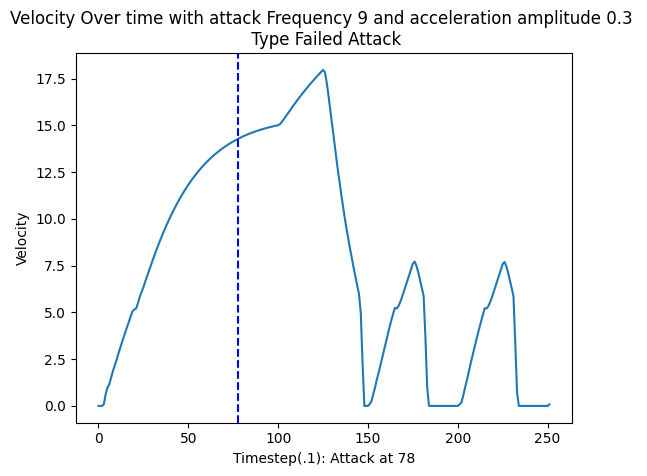

29


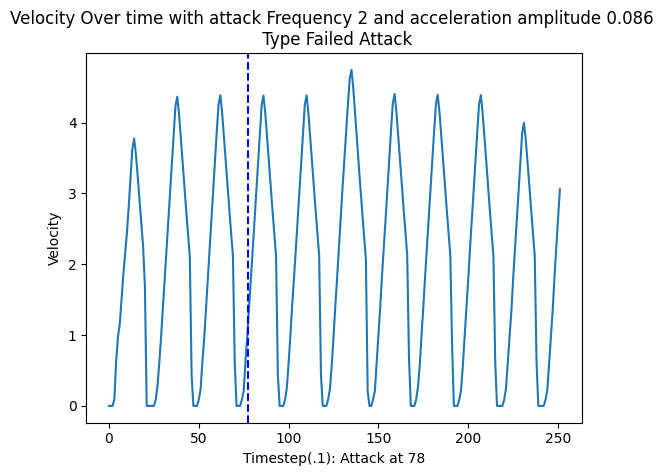

30


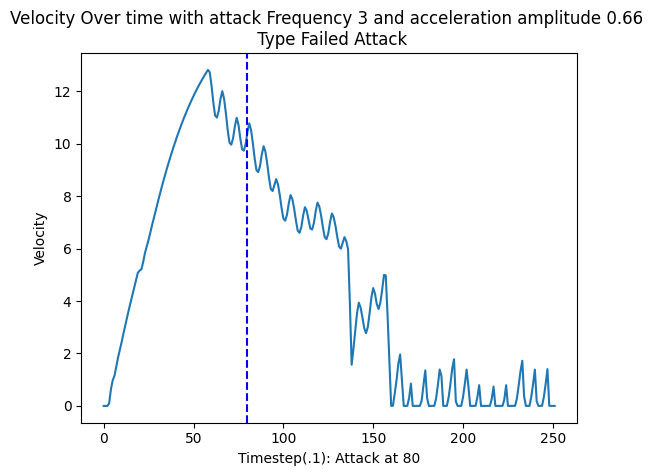

31


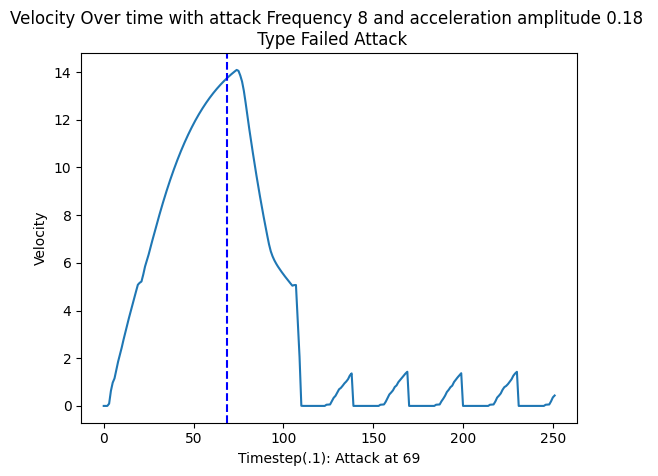

32


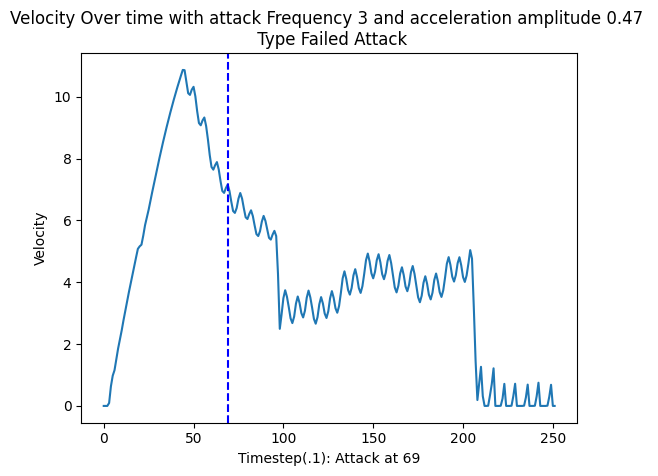

33


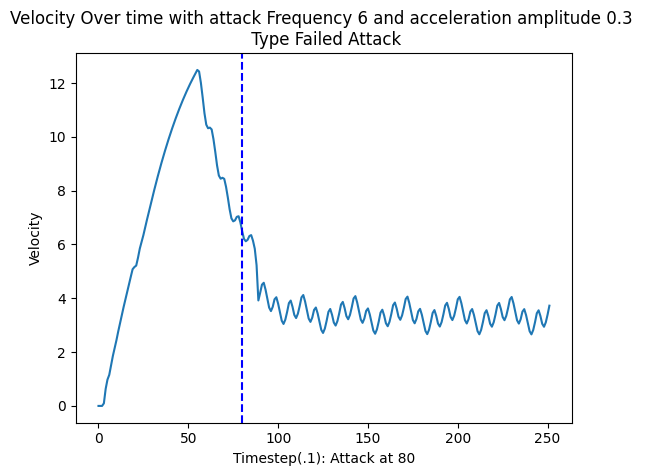

34


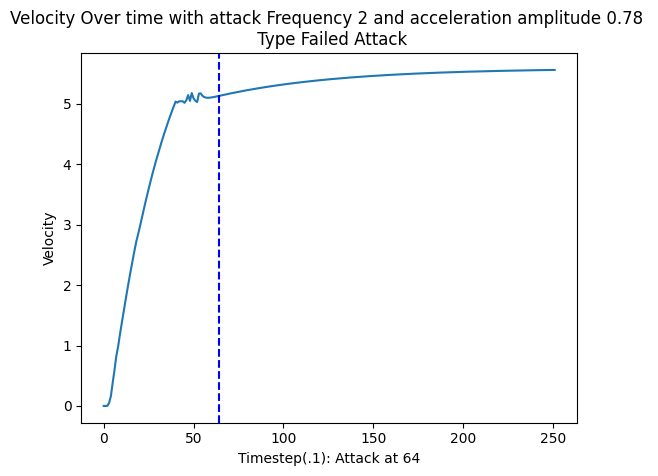

35


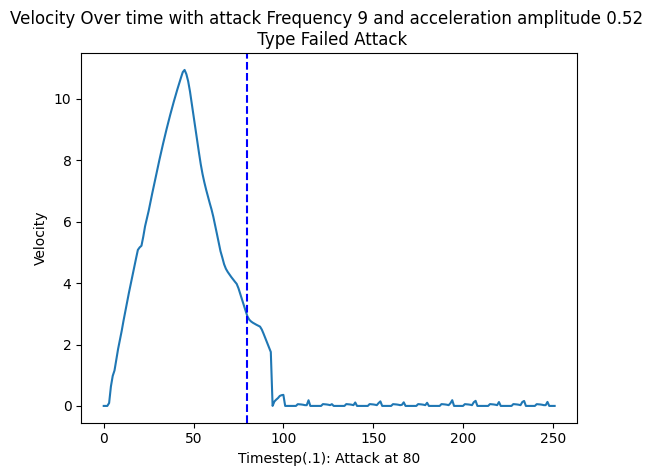

In [171]:
generate_persistent_attack_graphs(simulation_velocities_arr,all_data["point.params.frequency"],all_data['point.params.amplitude_acc'],all_data['point.params.attack_time'],ce,non_ce)


In [23]:
all_data["point.params.attack_time"]

0      7.401031
1      4.270911
2      2.192057
3      8.611773
4      3.981181
         ...   
495    6.075564
496    8.216608
497    8.449626
498    3.454678
499    9.225199
Name: point.params.attack_time, Length: 500, dtype: float64

In [ ]:
def generate_persistent_attack_graphs(sim_velocities,att_freq,att_amplitude,times): 
    """
    Graph Velocity over time w/ displayed amplitude    
    """
    for i in range(5):
        plt.figure()  #  (1, 500, 252)

        print(sim_velocities.shape)

        x = range(len(sim_velocities[0][i]))
        plt.plot(x,sim_velocities[0][i])

        plt.title(f"Velocity Over time with attack Frequency {int(att_freq[i])} and acceleration amplitude {att_amplitude[i]:.2g}")

        plt.xlabel(f"Timestep(.1): Attack at {times[i]*10:.2g}")
        plt.ylabel(f"Velocity")

        attack_time = times[i] * 10
        plt.axvline(x=attack_time, color='blue', linestyle='--', label="Attack Start")


        plt.show()


In [112]:
print(simulation_velocities_arr.shape)

(1, 500, 252)


# Curr work

Persistent_attack uses frequency to define how often the attack is applied. What are some interesting feature we can extract from this? 
 Total attacks?
 Time between attacks?
 Velocity at attack time would still be interesting just a bit more complex to extract.


Likely need to rerun data as there was a useless variable EGO_BRAKING_THESHOLD being included in the search space.. I am not sure how much of an effect this would have had but can always re run and see what happens

In [6]:
file_path = "../outputs/persistent_ce/persistent_attack_ce.csv"
dir_path = "../outputs/persistent_ce"

simulation_params_df = pd.read_csv("../outputs/persistent_ce/persistent_attack_ce.csv")

In [7]:
persistent_cols = [ "point.params.amplitude_acc", "point.params.attack_time", "point.params.frequency", "point.params.inter_vehicle_distance", "rho"]
intemittent_cols = ["point.params.random_thr_br1","point.params.random_thr_br2","point.params.inter_vehicle_distance", "point.params.random_t1", "point.params.random_t2","point.params.random_t3","point.params.random_t4","point.params.random_thr_br1","rho"]

In [8]:
evaluation_simulation_params_df = simulation_params_df[persistent_cols]
print(len(evaluation_simulation_params_df))

500


In [11]:
files = os.listdir(dir_path)
classified_files = classify_simulations(files)

In [12]:
evaluation_simulation_params_df.describe()

,point.params.amplitude_acc,point.params.attack_time,point.params.frequency,point.params.inter_vehicle_distance,rho
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.341717,6.507021,6.109624,11.331299,2.282775
std,0.274452,1.975794,2.955776,4.929331,4.627224
min,0.001723,0.036584,0.057499,7.008833,-0.273221
25%,0.124351,6.188735,3.267220,8.425303,0.066527
50%,0.265883,6.950120,6.355811,9.749395,0.242624
75%,0.534049,7.575427,9.023248,11.140633,1.478580
max,0.994191,9.980661,9.993043,29.065113,23.108299


In [13]:
vel_path = "../outputs/persistent_ce/persistent_attack.scenic500_velocities.csv"
vel_df = pd.read_csv(vel_path)

# Constructing features for the persistent Attack

In [18]:
attack_freq = evaluation_simulation_params_df["point.params.frequency"]
attack_amplitude = evaluation_simulation_params_df["point.params.amplitude_acc"]


In [ ]:
generate_persistent_attack_graphs(simulation_velocities_arr,attack_freq,attack_amplitude)

# Isolate different crash instances

In [17]:
evaluation_simulation_params_ce_df = evaluation_simulation_params_df[:len(classified_files[0])]
non_ce_idx = len(classified_files[1]) + len(classified_files[2])
evaluation_simulation_params_nce_df = evaluation_simulation_params_df[:non_ce_idx]

# So I thought it might be the case that the cross entropy sampler go this many results simply becuase it was concentrating at a certain set distance apart and this definitely seems to support that motion!

In [ ]:
simulation_params_df = pd.read_csv(sampler_file)